# Custmer churn prediction

Results of this exercise showed that Logistic regression gave the best model to predict churn followed closely by Random Forest. Below is a detailed report on my findings

In [51]:
# Load the packages
library(dplyr)
library(readr)
library(tidyr)
library(readxl)
library(lubridate)
library(ggplot2)
library(lattice)
library(caret)
library(car)
library(MASS)
library(rpart)

In [53]:
install.packages("rpart.plot", repos='http://cran.us.r-project.org')
library(rpart.plot)
install.packages("cowplot", repos='http://cran.us.r-project.org')
library(cowplot)

Warning message:
"package 'rpart.plot' is in use and will not be installed"Warning message:
"package 'cowplot' is in use and will not be installed"

In [54]:
install.packages("ROCR", repos='http://cran.us.r-project.org')
library(ROCR)

Warning message:
"package 'ROCR' is in use and will not be installed"

In [55]:
install.packages("e1071", repos='http://cran.us.r-project.org')
library(e1071) 

Warning message:
"package 'e1071' is in use and will not be installed"

In [56]:
install.packages("corrplot", repos='http://cran.us.r-project.org')
library(corrplot) 


  There is a binary version available but the source version is later:
         binary source needs_compilation
corrplot   0.84   0.87             FALSE



installing the source package 'corrplot'



In [57]:
install.packages("randomForest", repos='http://cran.us.r-project.org')
library(randomForest)

Warning message:
"package 'randomForest' is in use and will not be installed"

In [58]:
install.packages("pROC", repos='http://cran.us.r-project.org')
library(pROC)

Warning message:
"package 'pROC' is in use and will not be installed"

In [59]:
# Import data
data <- read_excel("Customer_Churn_Data_v2.xlsx")

### Exploratory Data Analysis

In [60]:
# Check the structure of dataset
str(data)

Classes 'tbl_df', 'tbl' and 'data.frame':	7432 obs. of  14 variables:
 $ cust_id                            : num  1 2 3 4 5 6 7 8 9 10 ...
 $ income                             : num  63863 51537 3298 14403 8636 ...
 $ debt_with_other_lenders            : num  87983 63655 4776 13925 10144 ...
 $ credit_score                       : num  20 17 2 5 3 7 1 8 7 2 ...
 $ has_previous_defaults_other_lenders: num  0 0 0 0 0 0 1 0 0 1 ...
 $ num_remittances_prev_12_mth        : num  22 20 26 18 21 21 13 24 21 18 ...
 $ remittance_amt_prev_12_mth         : num  23377 8354 1214 6203 6175 ...
 $ main_remittance_corridor           : chr  "AE_IN" "AE_PK" "AE_PK" "AE_IN" ...
 $ opened_campaign_1                  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ opened_campaign_2                  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ opened_campaign_3                  : num  0 0 0 0 0 1 0 0 0 0 ...
 $ opened_campaign_4                  : num  0 0 0 0 0 0 0 1 0 1 ...
 $ tenure_years                       : num  2.065 2.7

The raw data contains 7432 rows (customers) and 14 features. The 'churned' column is the target

In [61]:
#check missing values
sum(is.na(data))
colSums(is.na(data))

[1] 823

cust_id                              income 
                                  0                                 233 
            debt_with_other_lenders                        credit_score 
                                295                                 295 
has_previous_defaults_other_lenders         num_remittances_prev_12_mth 
                                  0                                   0 
         remittance_amt_prev_12_mth            main_remittance_corridor 
                                  0                                   0 
                  opened_campaign_1                   opened_campaign_2 
                                  0                                   0 
                  opened_campaign_3                   opened_campaign_4 
                                  0                                   0 
                       tenure_years                             churned 
                                  0                                   0

823 / 7432 or 11% missing values. When inspecting further we see they are not missing at random

Earned income does not include amounts such as pensions and annuities, welfare benefits, unemployment compensation, worker's compensation benefits, or social security benefits, which would explain NAs in income, as these customers were making regular payments too.

NA in debt with other lenders means they didn't have debt before

295 customers having missing credit score, is something ti be looked into further, for the purpose of this task I have converted all 0.

Therefore to tackle missing values, I've decided to convert all NAs

In [62]:
data <- data %>% mutate_all(funs(ifelse(is.na(.), 0, .))) #change all NAs to 0


#other methods I used to explore missingness:
#data <- data[complete.cases(data),] #complete case
#imputeds <-    #impute NA with median

### Data Wrangling

#### Change the values in columns 0 or 1 to “No” or “Yes”

In [63]:
data <- data %>% 
  mutate(churned = ifelse(churned == 1,'YES','NO'),
         has_previous_defaults_other_lenders = ifelse(has_previous_defaults_other_lenders == 1, 'YES', 'NO'),
         opened_campaign_1 = ifelse(opened_campaign_1 == 1, 'OPENED', 'UNOPENED'),
         opened_campaign_2 = ifelse(opened_campaign_2 == 1, 'OPENED', 'UNOPENED'),
         opened_campaign_3 = ifelse(opened_campaign_3 == 1, 'OPENED', 'UNOPENED'),
         opened_campaign_4 = ifelse(opened_campaign_4 == 1, 'OPENED', 'UNOPENED'))

#### Catorgorise tenure years

In [64]:
data<-data %>% 
  mutate(group_tenure = case_when(tenure_years < 0.5 ~ '0–6 Month',
                                  tenure_years >=0.5 & tenure_years < 1 ~ '6-12 Months',
                                  tenure_years >=1 & tenure_years < 1.5 ~ '12-18 Months', 
                                  tenure_years >=1.5 & tenure_years < 2 ~ '18-24 Months',
                                  tenure_years >=2 & tenure_years < 2.5 ~ '24-30 Months',
                                  tenure_years >=2.5 ~ '>30 Months'))

#### Remove the columns we do not need for the analysis.

In [65]:
data$cust_id <- NULL
data$tenure_years<- NULL

### Feature selection

#### Correlation between numeric variables

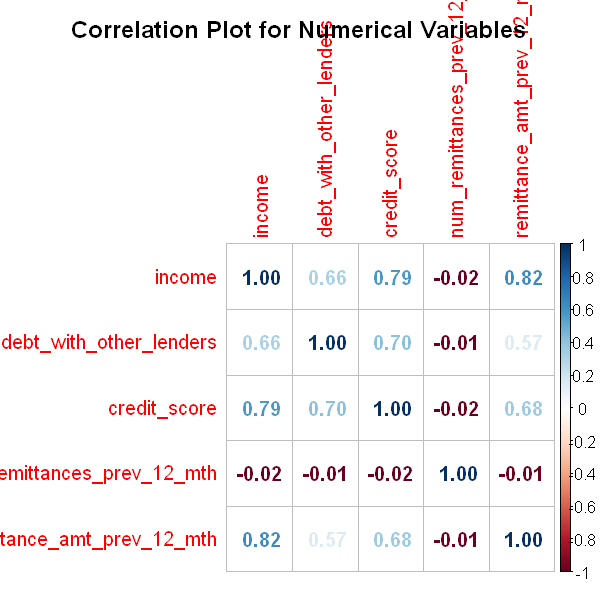

In [66]:
corr.matrix<-cor(data[, sapply(data, is.numeric)],
    use = "complete.obs", method = "pearson")
options(repr.plot.width = 5, repr.plot.height = 5)
corrplot(corr.matrix, main="\n\nCorrelation Plot for Numerical Variables", method="number",is.corr = T)

Income, Credit Score and Remittance amount are highly correlated. So remittance_amt_prev_12_mth and credit_score will be removed

In [67]:
data$remittance_amt_prev_12_mth <- NULL
data$credit_score <- NULL

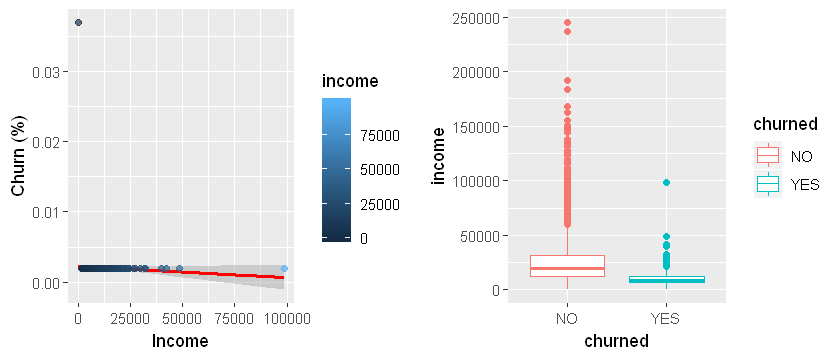

In [68]:
# Decrease graph size from standard
options(repr.plot.width = 7, repr.plot.height = 3)
plot_grid(
data %>%
    filter(churned == "YES") %>%
    group_by(income) %>%
    summarize(
        n = n()
    ) %>%
    mutate(
        Percentage = round(n / sum(n), 3)
    ) %>%
    # Create plot
    ggplot(
        aes(x = income, y = Percentage, color = income)
    ) +
    stat_smooth(method = "lm", col = "red") +
    geom_point(alpha = 2/3) +
    # Clean graph visual a bit
  #  theme +
    labs(
        x = "Income", y = "Churn (%)"
    ),

ggplot(
    data = data,
    aes(y = income, x = churned, color = churned)
    ) +
  #  theme +
    geom_boxplot()
, align = "h")

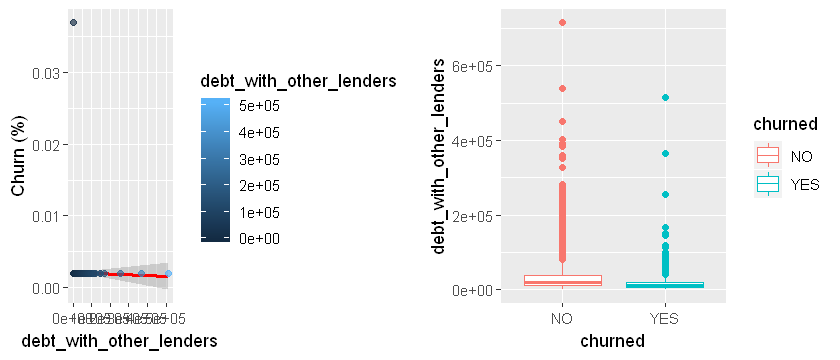

In [69]:
# Decrease graph size from standard
options(repr.plot.width = 7, repr.plot.height = 3)
plot_grid(
data %>%
    filter(churned == "YES") %>%
    group_by(debt_with_other_lenders) %>%
    summarize(
        n = n()
    ) %>%
    mutate(
        Percentage = round(n / sum(n), 3)
    ) %>%
    # Create plot
    ggplot(
        aes(x = debt_with_other_lenders, y = Percentage, color = debt_with_other_lenders)
    ) +
    stat_smooth(method = "lm", col = "red") +
    geom_point(alpha = 2/3) +
    # Clean graph visual a bit
  #  theme +
    labs(
        x = "debt_with_other_lenders", y = "Churn (%)"
    ),

ggplot(
    data = data,
    aes(y = debt_with_other_lenders, x = churned, color = churned)
    ) +
  #  theme +
    geom_boxplot()
, align = "h")

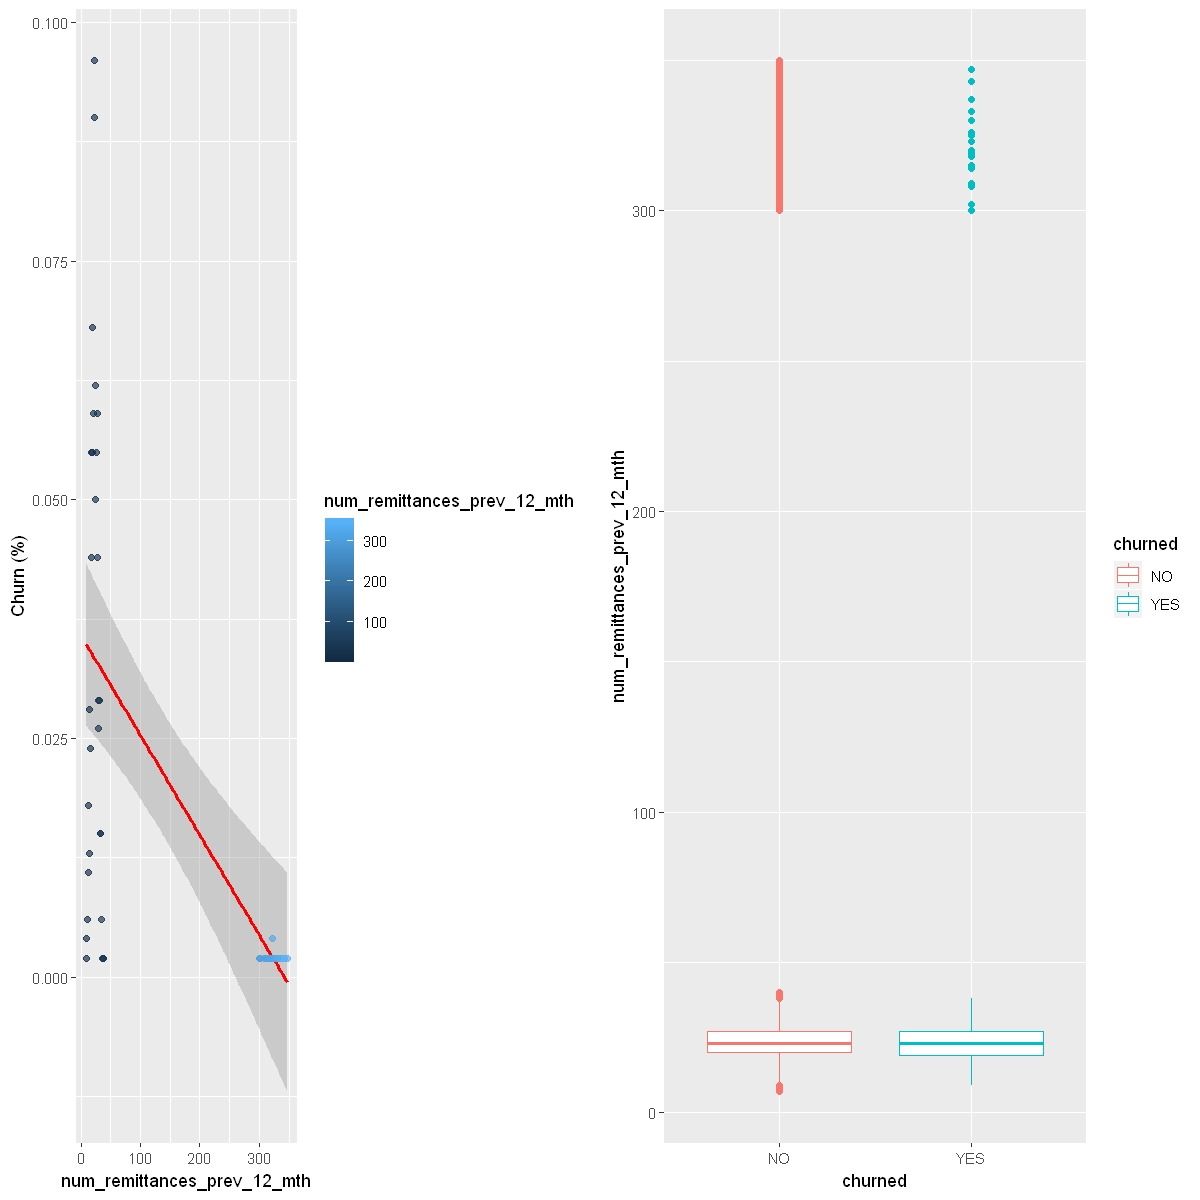

In [70]:
# Decrease graph size from standard
options(repr.plot.width = 10, repr.plot.height = 10)
plot_grid(
data %>%
    filter(churned == "YES") %>%
    group_by(num_remittances_prev_12_mth) %>%
    summarize(
        n = n()
    ) %>%
    mutate(
        Percentage = round(n / sum(n), 3)
    ) %>%
    # Create plot
    ggplot(
        aes(x = num_remittances_prev_12_mth, y = Percentage, color = num_remittances_prev_12_mth)
    ) +
    stat_smooth(method = "lm", col = "red") +
    geom_point(alpha = 2/3) +
    # Clean graph visual a bit
  #  theme +
    labs(
        x = "num_remittances_prev_12_mth", y = "Churn (%)"
    ),

ggplot(
    data = data,
    aes(y = num_remittances_prev_12_mth, x = churned, color = churned)
    ) +
  #  theme +
    geom_boxplot()
, align = "h")

Some customers had made over 300 remittances over 12 months, which means ~ 25 payments per month. This doesn't seem correct and therefore classed as outliers and should be removed

In [71]:
data <- data %>% filter(num_remittances_prev_12_mth < 200)

#### Bar plots of categorical variables

In [72]:
# How many churns in this dataset ?
#Count churned or not
data %>% count(churned)

churned,n
NO,6626
YES,526


1 - stopped using   
0 - continued using

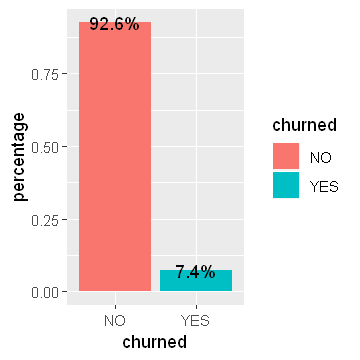

In [73]:
data <- data %>%
  mutate(
    # column was int but best to have it as logical
    churned = as.factor(churned)
  )

options(repr.plot.width = 3, repr.plot.height = 3)

data %>%
  group_by(churned) %>%
  summarize(
    n = n()
  ) %>%
  mutate(
    percentage = round(n / sum(n), 3),
    n = NULL
  ) %>%
  ggplot(aes(x = churned, y = percentage)) + geom_col(aes(fill = churned)) +
  theme() +
  geom_text(
    aes(x = churned, y = percentage, label = paste(percentage*100, "%", sep = ""))
  )


#### 7.4% of customers in this dataset have churned.

#### Next, I'll explore other columns with a function to output multiple graphs at once.

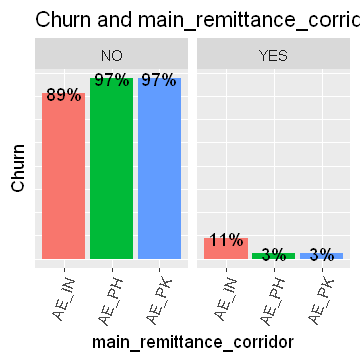

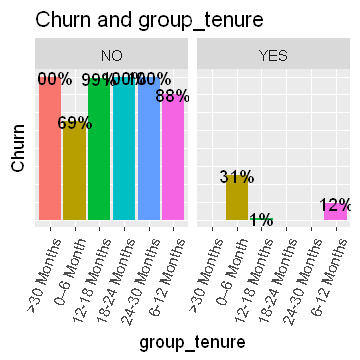

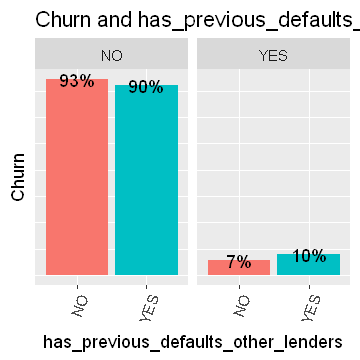

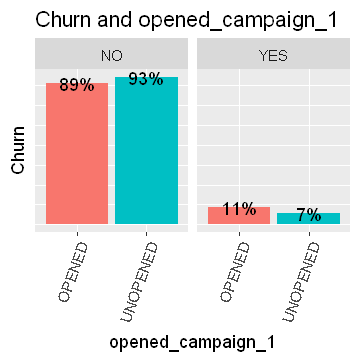

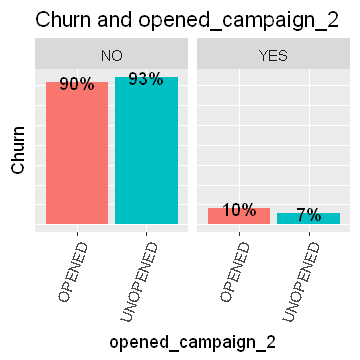

ERROR: Can't bind data because some arguments have the same name

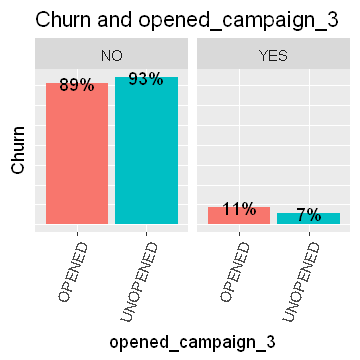

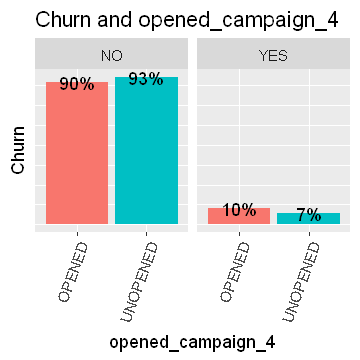

In [74]:
# Decrease graph size from standard
options(repr.plot.width = 3, repr.plot.height = 3)

# Function to generate graphs for factor variables and churn

## Extract columns to be analyzed
function_columns <- data %>%
  dplyr::select(
    
    'main_remittance_corridor', 'group_tenure', 'has_previous_defaults_other_lenders',
    'opened_campaign_1', 'opened_campaign_2', 'opened_campaign_3', 'opened_campaign_4','churned'
  )

## Function, goes through each column selected
for (i in 1:ncol(function_columns))
{
  # Get column names so dplyr group by works
  cname <- colnames(function_columns[c(i,8)])
  # Subset data frame by variable name selected
  a <- subset(
    function_columns, !is.na(function_columns[,i]) & function_columns[,i] != "",
    select = cname
  ) %>%
    # Create percentage statistics per variable
    group_by_at(vars(cname)) %>%
    summarize(
      n = n()
    ) %>%
    mutate(
      Percentage = round(n / sum(n), 2)
    )
  
  # Save plot in a variable so plots can be displayed sequentialy
  p <- ggplot(
    data = a, aes_string(
      x = colnames(a[1]), y = colnames(a[4]), fill = colnames(a[1])
    )
  ) +
    # Split each graph per Churn to see influence of variable
    facet_wrap("churned") + 
    geom_bar(stat = "identity") +
    # Make graph a bit cleaner
    theme(
      axis.text.y = element_blank(), axis.ticks.y = element_blank(),
      axis.text.x = element_text(angle = 70, hjust = 1),
      legend.position="none"
    ) +
    geom_text(
      aes(y = Percentage, label = paste0(Percentage * 100,"%"))
    ) +
    labs(
      x = colnames(a[1]), y = "Churn", title = paste("Churn and", colnames(a[1]))
    )
  
  # Display graphs
  print(p)
  # Cleanup
  rm(cname, a, p)
}


We can see, having previous defaults, and all 4 Opened campaigns do not seem to have an influence on churn.

Some characteristics of data points with higher churn:
'income', 'debt_with_other_lenders', 
    'num_remittances_prev_12_mth', 'main_remittance_corridor', 'group_tenure' have a higher churn rate.

### Data cleaning and preparation

#### Removing columns we won't analyze

From the above, previous_defaults_other_lenders, and all 4 opened campaigns will also be removed.



In [76]:
# Remove columns we didn't see influence on churn from above
data.model <- data %>%
    dplyr::select(
        -has_previous_defaults_other_lenders, -opened_campaign_1, -opened_campaign_2,-opened_campaign_3, -opened_campaign_4 
    )

In [77]:
data.model=data.model %>% mutate_if(is.character, as.factor)

Split train and test data
Training dataset will have 75% of the original data.

In [78]:
# Set seed
set.seed(123)

# Split data, 75% distribution of churn for training
train.index <- createDataPartition(
    y = data.model$churned, p = 0.75, list = FALSE
)

train <- data.model[train.index,]
test <- data.model[-train.index,]

## Decision Tree

A decision tree is a supervised machine learning algorithm that can be used for both classification and regression problems. A decision tree is simply a series of sequential decisions made to reach a specific result. A decision tree can give a nice and easy visualization of the prediction rules.
They are easy to understand and interpret, perfect for visual representation
Requires little data preprocessing: no need for one-hot encoding, dummy variables, and so on.
Non-parametric model: no assumptions about the shape of data.
However a small change in the data can cause a large change in the structure of the decision tree causing instability also it is inadequate for applying regression and predicting continuous values.

In [79]:
# Fit model
tree.fit <- rpart(
  churned ~ ., 
  data = data.model, 
  method = "class"
)

Confusion Matrix and Statistics

          Reference
Prediction   NO  YES
       NO  1643   34
       YES   13   97
                                          
               Accuracy : 0.9737          
                 95% CI : (0.9652, 0.9806)
    No Information Rate : 0.9267          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.791           
                                          
 Mcnemar's Test P-Value : 0.003531        
                                          
            Sensitivity : 0.9921          
            Specificity : 0.7405          
         Pos Pred Value : 0.9797          
         Neg Pred Value : 0.8818          
             Prevalence : 0.9267          
         Detection Rate : 0.9194          
   Detection Prevalence : 0.9384          
      Balanced Accuracy : 0.8663          
                                          
       'Positive' Class : NO              
                        

[1] "AUC Value is: 0.963081277427444"

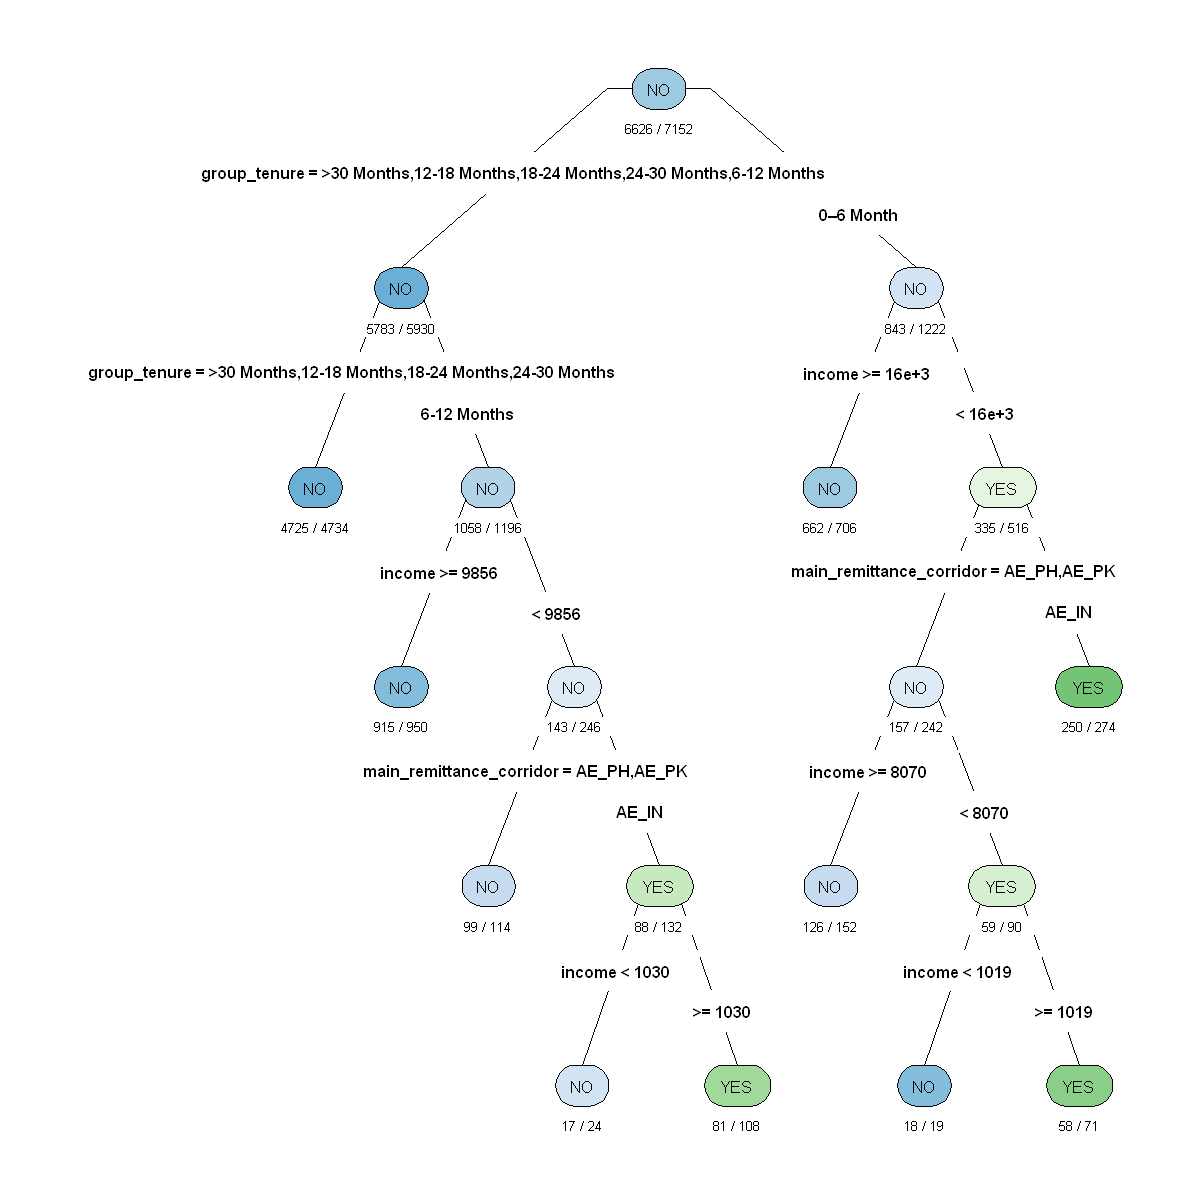

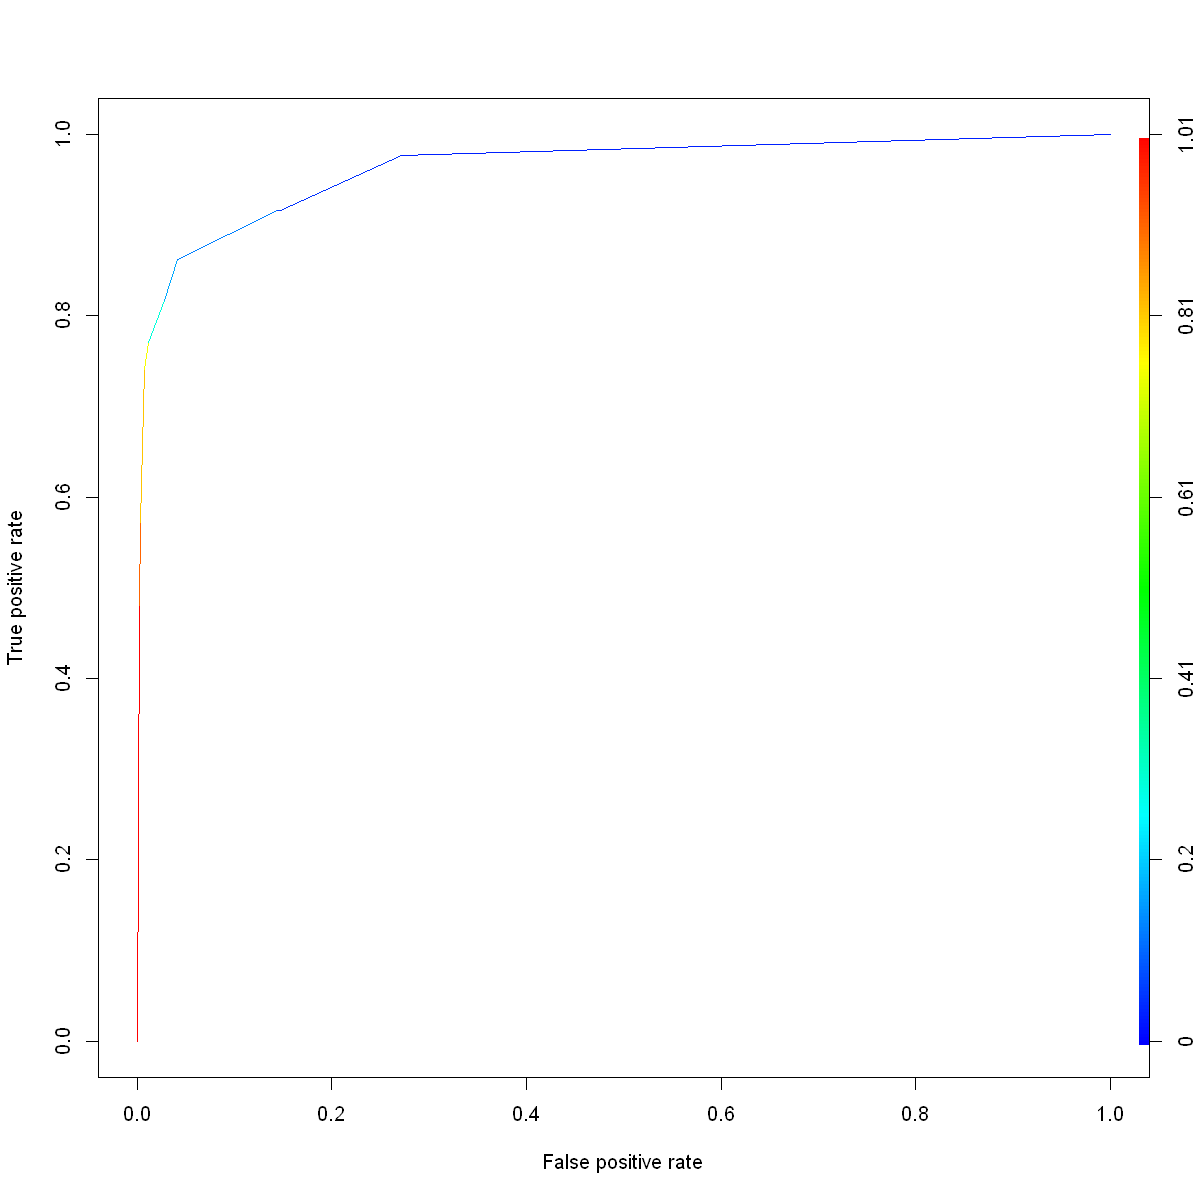

In [80]:
options(repr.plot.width = 10, repr.plot.height = 10)

# Graph of tree
rpart.plot(
  tree.fit,
  type = 4,
  extra = 2,
  under = TRUE,
  fallen.leaves = F
)

# Prediction, classification
tree.pred <- predict(
  tree.fit,
  test, 
  type = "class"
)

confusionMatrix(
  tree.pred,as.factor(test$churned)
)

# Prediction, probability
tree.pred.prob <- predict(
  tree.fit, 
  test, 
  type = "prob"
)
tree.pred.prob.val <- prediction(
  tree.pred.prob[,2],
  test$churned
)
tree.pred.prob.perf <- performance(
  tree.pred.prob.val,
  "auc"
)

# print AUC value
paste(
  "AUC Value is:", 
  as.numeric(performance(
    tree.pred.prob.val, 
    "auc"
  )@y.values
  )
)
# plots the ROC curve with colors where the splits are.
plot(performance(tree.pred.prob.val, "tpr", "fpr"), colorize = TRUE)

# Random Forest

Random Forests are robust to outliers and work really well with non linear data. There is also lower risk of overfitting and has better acuracy than decision trees. Downside is that they are very slow running and can be biased when dealing with catergorical variables

In [81]:
#rf.fit  <- train(churned ~ . , method = "rf", data = train, importance = TRUE)

#rf.pred <- predict(rf.fit, test)

In [82]:
rf.fit <- randomForest(as.factor(churned) ~., data = train)
rf.pred <- predict(rf.fit, test)

In [83]:
rf.fit


Call:
 randomForest(formula = as.factor(churned) ~ ., data = train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 3.06%
Confusion matrix:
      NO YES class.error
NO  4919  51  0.01026157
YES  113 282  0.28607595

In [84]:
confusionMatrix(rf.pred, as.factor(test$churned))
#performance(rf.pred, measure = "auc")@y.values[[1]]


Confusion Matrix and Statistics

          Reference
Prediction   NO  YES
       NO  1641   33
       YES   15   98
                                          
               Accuracy : 0.9731          
                 95% CI : (0.9645, 0.9801)
    No Information Rate : 0.9267          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.7889          
                                          
 Mcnemar's Test P-Value : 0.01414         
                                          
            Sensitivity : 0.9909          
            Specificity : 0.7481          
         Pos Pred Value : 0.9803          
         Neg Pred Value : 0.8673          
             Prevalence : 0.9267          
         Detection Rate : 0.9183          
   Detection Prevalence : 0.9368          
      Balanced Accuracy : 0.8695          
                                          
       'Positive' Class : NO              
                        

[1] "AUC Value is: 0.984364052070657"

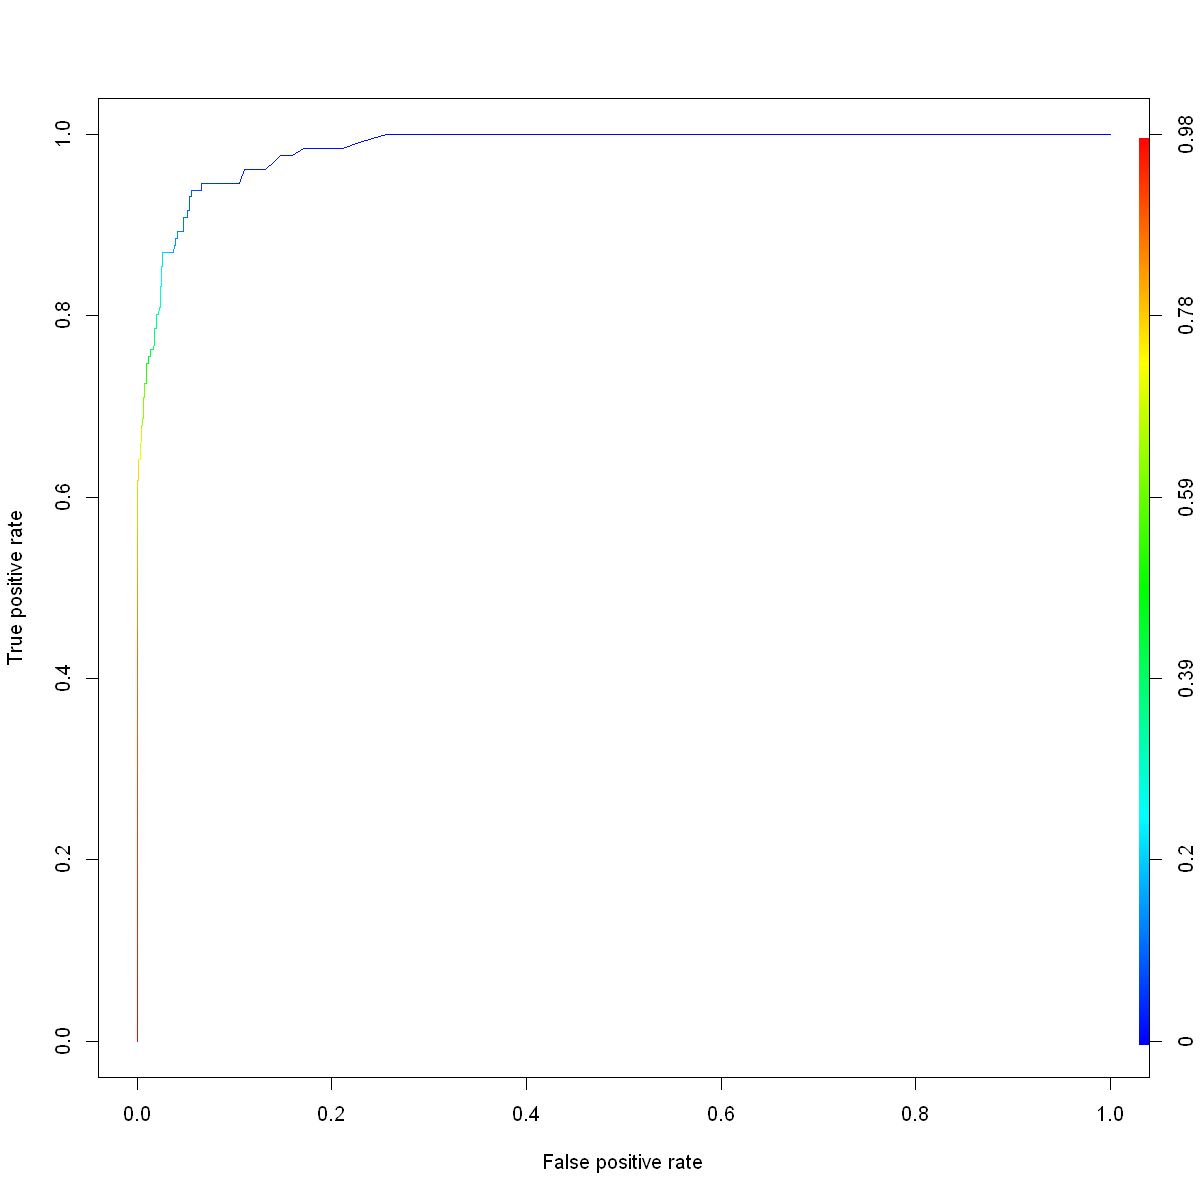

In [85]:
# Prediction, probability
rf.pred.prob <- predict(
  rf.fit, 
  test, 
  type = "prob"
)
rf.pred.prob.val <- prediction(
  rf.pred.prob[,2],
  test$churned
)
rf.pred.prob.perf <- performance(
  rf.pred.prob.val,
  "auc"
)

# print AUC value
paste(
  "AUC Value is:", 
  as.numeric(performance(
    rf.pred.prob.val, 
    "auc"
  )@y.values
  )
)
# plots the ROC curve with colors where the splits are.
plot(performance(rf.pred.prob.val, "tpr", "fpr"), colorize = TRUE)

Compared to Decision Tree, Random Forest had slightly higher accuracy (0.972 vs 0.974) and specificity (0.75 vs 0.74) and higher AUC (0.98 vs 0.96).
Sensitivity for both were equal (0.99 vs 0.99).
The models were statisitically significant with p value =  2.2e-16.

## Logistic Regression

Logisitic regressions are easier to implement, interpret and very efficient to train. Also it not only provides a measure of how appropriate a predictor(coefficient size)is, but also its direction of association (positive or negative). The major limitation of Logistic Regression is the assumption of linearity between the dependent variable and the independent variables. 

In [86]:
# full logistic model 

logisticModelFull <- glm(as.factor(churned) ~ ., family = "binomial", data.model)

summary(logisticModelFull)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = as.factor(churned) ~ ., family = "binomial", data = data.model)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.9619  -0.0644   0.0000   0.0000   4.3675  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -1.789e+01  6.744e+02  -0.027    0.979    
income                        -2.455e-04  1.309e-05 -18.748  < 2e-16 ***
debt_with_other_lenders        2.533e-05  3.369e-06   7.520 5.46e-14 ***
num_remittances_prev_12_mth   -1.794e-02  1.403e-02  -1.279    0.201    
main_remittance_corridorAE_PH -2.395e+00  2.458e-01  -9.745  < 2e-16 ***
main_remittance_corridorAE_PK -2.502e+00  1.821e-01 -13.739  < 2e-16 ***
group_tenure0–6 Month          2.199e+01  6.744e+02   0.033    0.974    
group_tenure12-18 Months       1.607e+01  6.744e+02   0.024    0.981    
group_tenure18-24 Months      -3.946e-01  9.449e+02   0.000    1.000    
group_tenure24-30 Months       7.135e-03  9.514e+02   0.

In [87]:
# new model (optimize model by finding the min. AIC value)
logisticModelNew <-  stepAIC(logisticModelFull, trace = 0)
summary(logisticModelNew)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = as.factor(churned) ~ income + debt_with_other_lenders + 
    main_remittance_corridor + group_tenure, family = "binomial", 
    data = data.model)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.9579  -0.0645   0.0000   0.0000   4.4253  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -1.829e+01  6.746e+02  -0.027    0.978    
income                        -2.456e-04  1.311e-05 -18.736  < 2e-16 ***
debt_with_other_lenders        2.519e-05  3.400e-06   7.409 1.28e-13 ***
main_remittance_corridorAE_PH -2.396e+00  2.453e-01  -9.768  < 2e-16 ***
main_remittance_corridorAE_PK -2.497e+00  1.818e-01 -13.734  < 2e-16 ***
group_tenure0–6 Month          2.198e+01  6.746e+02   0.033    0.974    
group_tenure12-18 Months       1.606e+01  6.746e+02   0.024    0.981    
group_tenure18-24 Months      -4.023e-01  9.451e+02   0.000    1.000    
group_tenure24-30 Months      -9.931e-03  9.51

### Out-of-sample validation and cross validation

In [88]:
# modeling 
lr.fit <-glm(formula = as.factor(churned) ~ income + debt_with_other_lenders + main_remittance_corridor + 
    group_tenure, family = "binomial", data = train)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

In [89]:
#prediction 
probabilities <- lr.fit %>% predict(test, type = "response")
predicted.classes <- ifelse(probabilities > 0.5, "YES", "NO")

In [90]:
confusionMatrix(data = as.factor(predicted.classes), as.factor(test$churned))


Confusion Matrix and Statistics

          Reference
Prediction   NO  YES
       NO  1638   42
       YES   18   89
                                         
               Accuracy : 0.9664         
                 95% CI : (0.957, 0.9743)
    No Information Rate : 0.9267         
    P-Value [Acc > NIR] : 6.696e-13      
                                         
                  Kappa : 0.7301         
                                         
 Mcnemar's Test P-Value : 0.002985       
                                         
            Sensitivity : 0.9891         
            Specificity : 0.6794         
         Pos Pred Value : 0.9750         
         Neg Pred Value : 0.8318         
             Prevalence : 0.9267         
         Detection Rate : 0.9166         
   Detection Prevalence : 0.9401         
      Balanced Accuracy : 0.8343         
                                         
       'Positive' Class : NO             
                                         

Setting levels: control = NO, case = YES
Setting direction: controls < cases


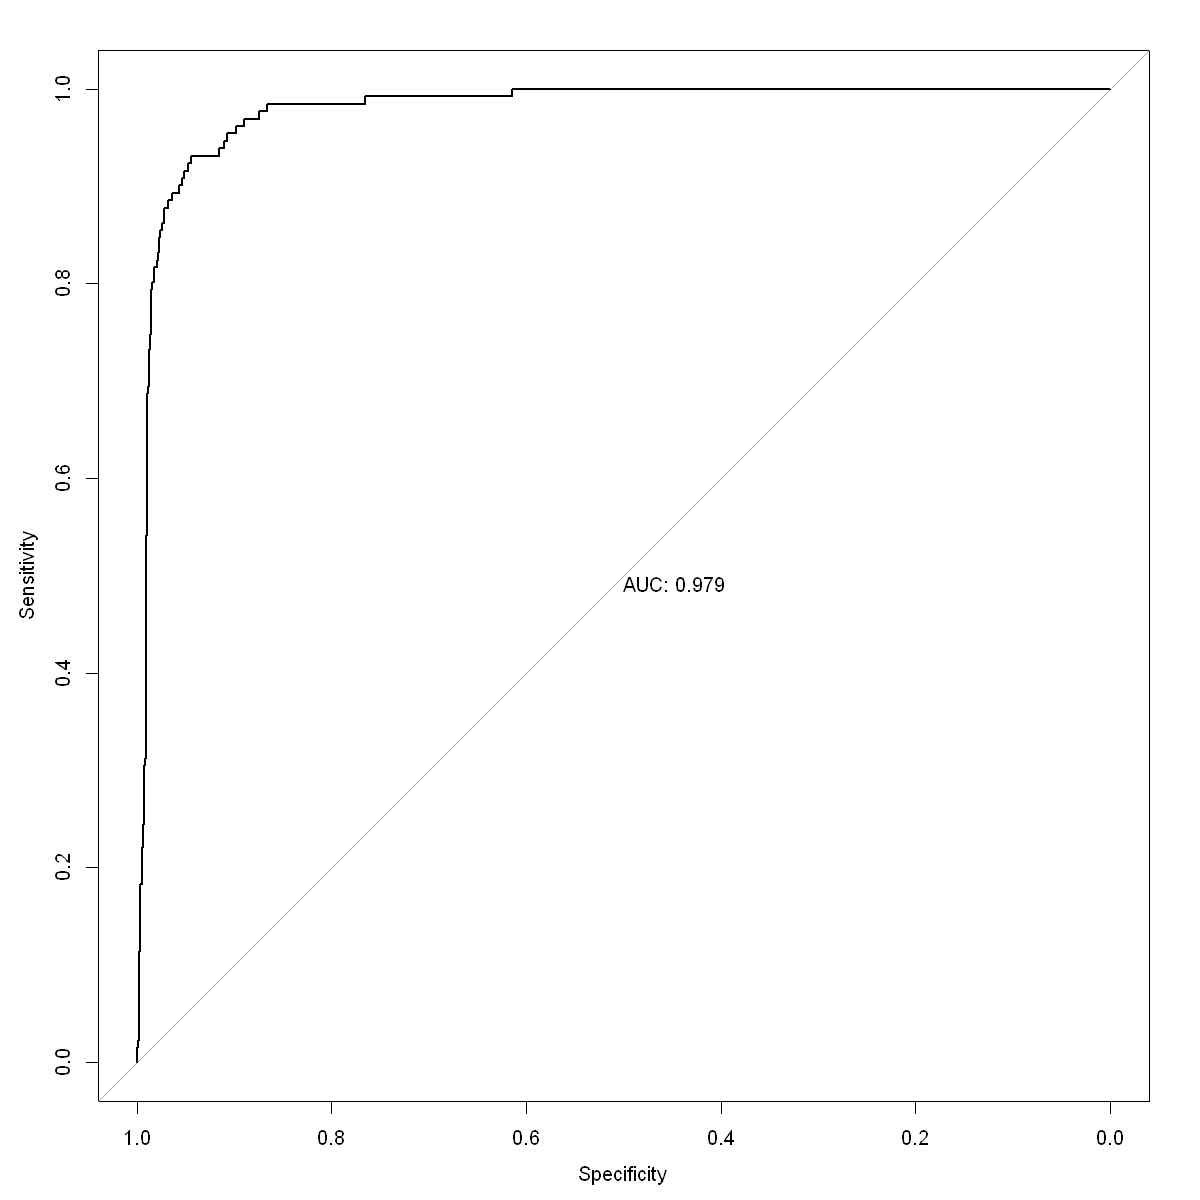

In [91]:
probabilities <- lr.fit %>% predict(test, type = "response")
test_roc = roc(test$churned ~ probabilities, plot = TRUE, print.auc = TRUE)

All three models were statistically significant (p = < 2e-16)

The decision tree above has accuracy of 0.97. 

For all three: Accuracy were 0.97, with random forest and logistic regression scoring slightly higher, and sensitivty was 0.99 

Specificity was 0.75 for logisitc and the highest out of the three models, random forest and decision tree both scored 0.73 and 0.72 respectively

AUC was 0.989 for logisitci regression , 0.98 for random forest and 0.95 for decision tree.

Overall logistic regression scored highly with random forest with slighty lower scores. Deciision tree had the weakest model, however all three models scored very highly.

## Cross Validation

Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data

In [92]:
#k-fold cross val in caret
set.seed(10)

# train control
fitControl <- trainControl(## 10-fold CV
                            method = "repeatedcv",
                            number = 10,
                            ## repeated 3 times
                            repeats = 3,
                            classProbs = TRUE,
                            summaryFunction = twoClassSummary)



In [93]:
# logistic regression model
logreg <- train(churned ~., train,
                  method = "glm",
                  family = "binomial",
                  trControl = fitControl,
                  metric = "ROC")

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning mess

In [94]:
logreg 


Generalized Linear Model 

5365 samples
   5 predictor
   2 classes: 'NO', 'YES' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 4828, 4828, 4829, 4829, 4828, 4829, ... 
Resampling results:

  ROC        Sens       Spec    
  0.9787045  0.9873239  0.638547


In [95]:
# random forest model
rf <- train(churned ~., train,
                  method = "rf",
                  trControl = fitControl,
                  metric = "ROC")


In [96]:
rf

Random Forest 

5365 samples
   5 predictor
   2 classes: 'NO', 'YES' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 4829, 4828, 4828, 4829, 4828, 4829, ... 
Resampling results across tuning parameters:

  mtry  ROC        Sens       Spec     
   2    0.9688070  0.9977867  0.4178632
   6    0.9749082  0.9880617  0.7232265
  10    0.9668340  0.9852448  0.7207051

ROC was used to select the optimal model using the largest value.
The final value used for the model was mtry = 6.

In [97]:
# decision tree model
dt <- train(churned ~., train,
                  method = "rpart",
                  trControl = fitControl,
                  metric = "ROC")




In [98]:
dt

CART 

5365 samples
   5 predictor
   2 classes: 'NO', 'YES' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 4828, 4829, 4829, 4829, 4828, 4829, ... 
Resampling results across tuning parameters:

  cp          ROC        Sens       Spec     
  0.03797468  0.8380684  0.9877264  0.5103419
  0.09873418  0.8356910  0.9773977  0.5818376
  0.14303797  0.6460846  0.9839034  0.2819444

ROC was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.03797468.


Call:
summary.resamples(object = results)

Models: LR, RF, DT 
Number of resamples: 30 

ROC 
        Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
LR 0.9576433 0.9763272 0.9786927 0.9787045 0.9820103 0.9896817    0
RF 0.9503773 0.9680261 0.9743848 0.9749082 0.9869215 0.9911469    0
DT 0.7464789 0.8151150 0.8322241 0.8380684 0.8635752 0.9375755    0

Sens 
        Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
LR 0.9718310 0.9859155 0.9889336 0.9873239 0.9899396 0.9959759    0
RF 0.9778672 0.9864185 0.9879276 0.9880617 0.9899396 0.9979879    0
DT 0.9738431 0.9823944 0.9869215 0.9877264 0.9934608 0.9979879    0

Spec 
        Min.   1st Qu.    Median      Mean   3rd Qu.  Max. NA's
LR 0.4871795 0.5641026 0.6500000 0.6385470 0.6980769 0.800    0
RF 0.5384615 0.7000000 0.7435897 0.7232265 0.7644231 0.800    0
DT 0.3250000 0.4528846 0.5000000 0.5103419 0.5471154 0.725    0


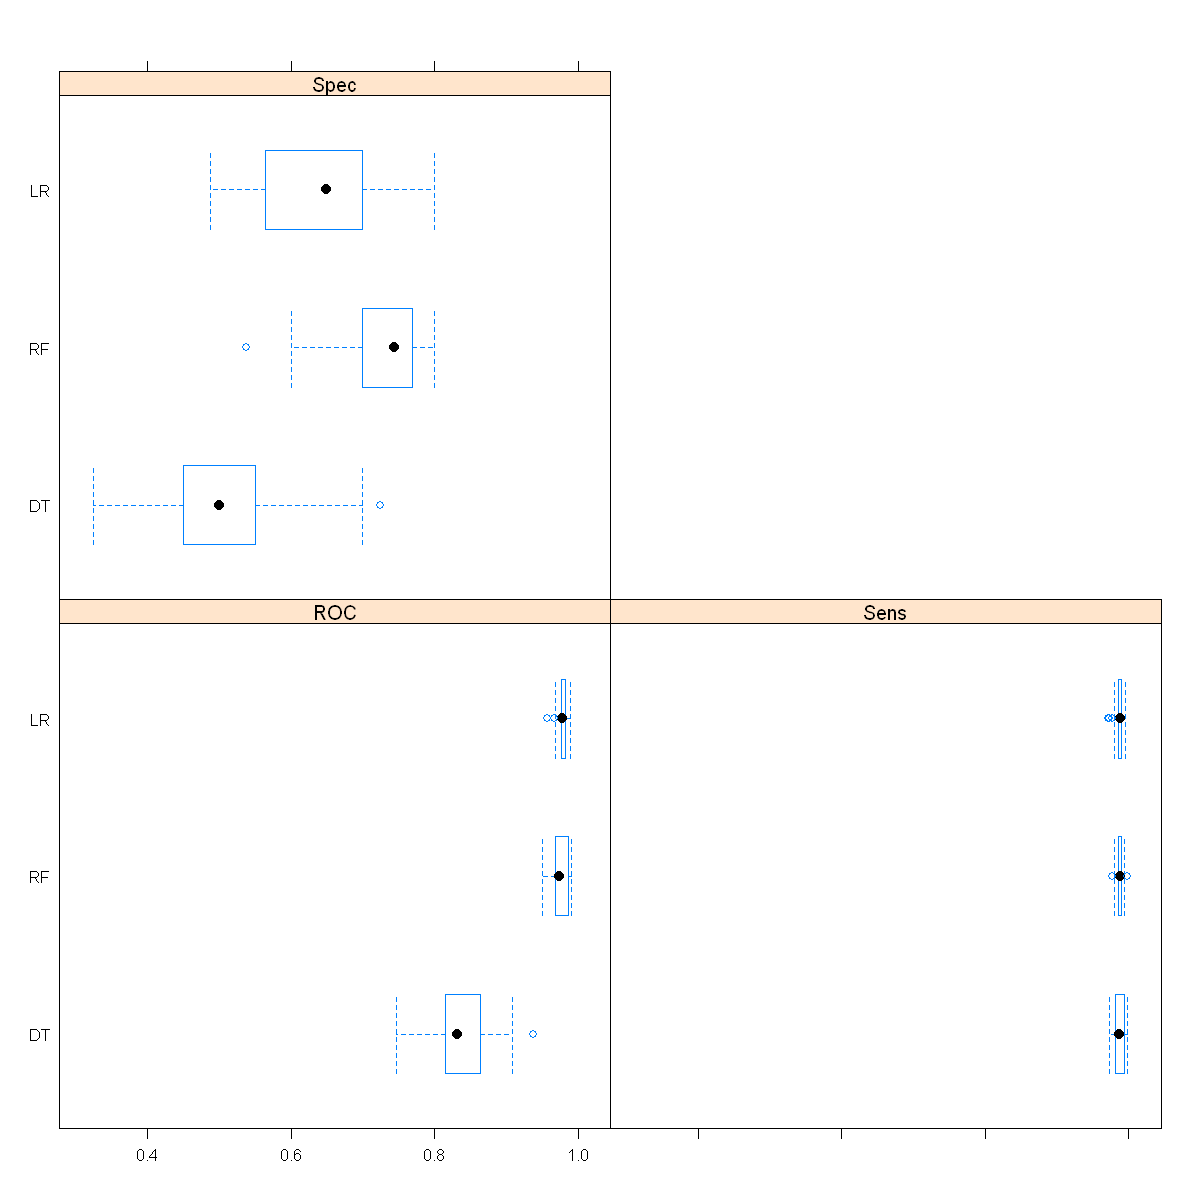

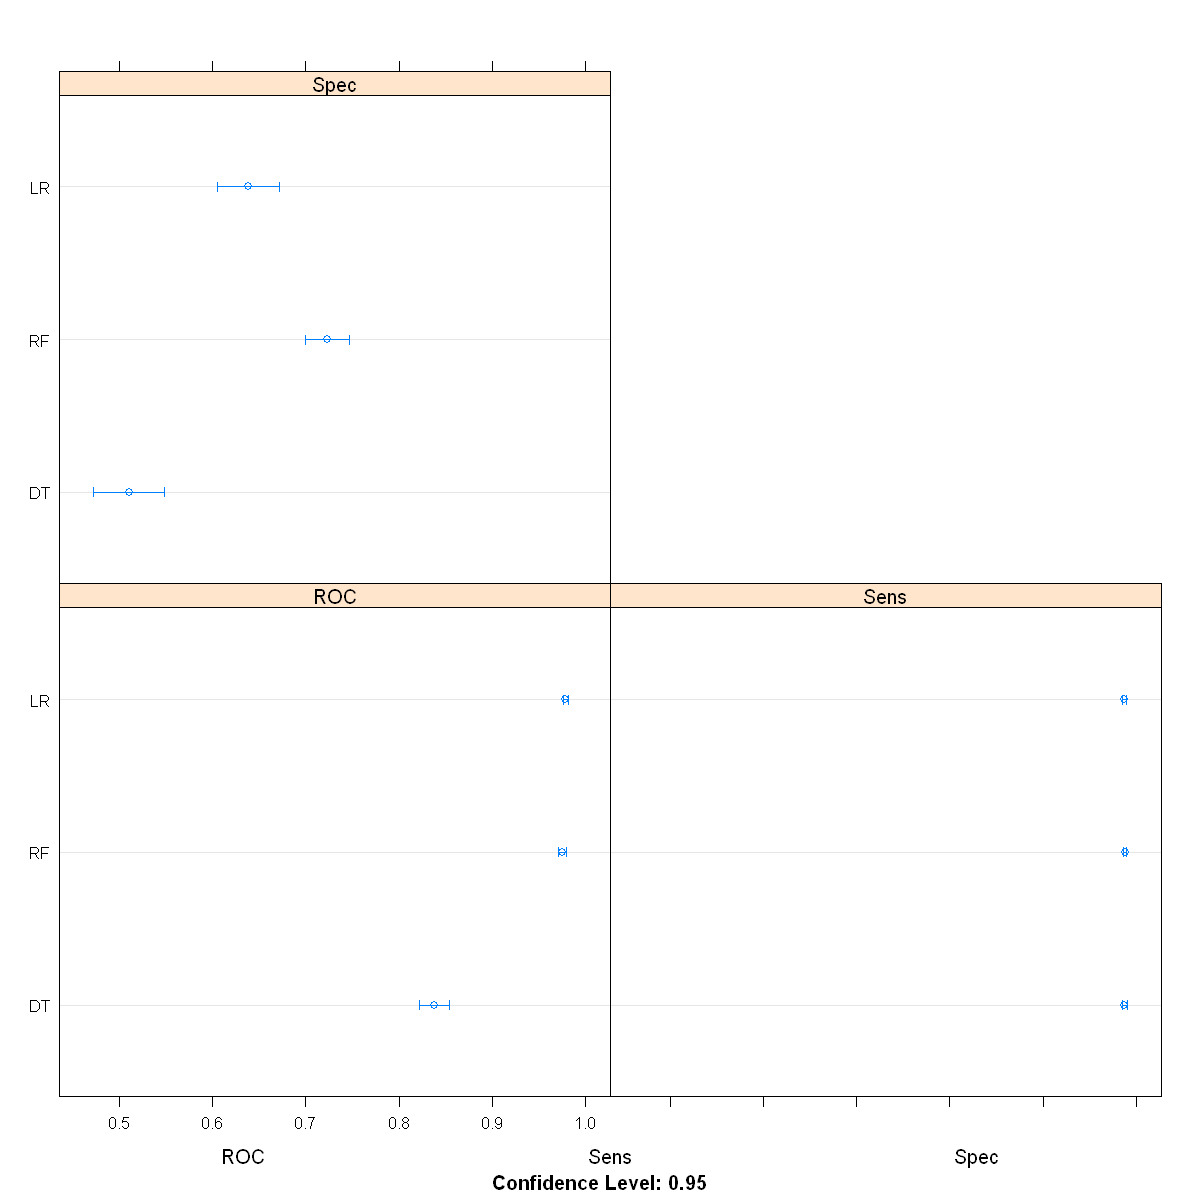

In [99]:
# collect resamples
results <- resamples(list(LR=logreg, RF=rf, DT=dt))
# summarize the distributions
summary(results)
# boxplots of results
bwplot(results)
# dot plots of results
dotplot(results)

The logistic regression model had an average ROC of 0.979, the random forest model had an average ROC of approximately 0.975, and decision tree had 0.838

Overall logisitic regression had high sensitivity (0.987), as well as a specificity of 0.64. Random Forest did well too in terms of AUC and sensitivity (0.988), the specificity had value of 0.723 which was slightly higher than specificty of log reg (0.639). 

Decision Tree was the weakest model out of logistisc regression and random forest with ROC, sensitivity and specifity being 0.838, 0.988, 0.510 respectively. 

# Final model - Logistic Regression

Though Random forest scored slightly better in specificity, logistic regression was chosen as the most powerful model due to scoring better in ROC and sensitivity, as well as in accuracy in other models. Therefore Log regression was used to predict churn out of the models.

In [101]:
# logistic regression model
logreg <- train(churned ~., data.model,
                  method = "glm",
                  family = "binomial")

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning mess

In [102]:
summary(logreg)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.9619  -0.0644   0.0000   0.0000   4.3675  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -1.789e+01  6.744e+02  -0.027    0.979    
income                        -2.455e-04  1.309e-05 -18.748  < 2e-16 ***
debt_with_other_lenders        2.533e-05  3.369e-06   7.520 5.46e-14 ***
num_remittances_prev_12_mth   -1.794e-02  1.403e-02  -1.279    0.201    
main_remittance_corridorAE_PH -2.395e+00  2.458e-01  -9.745  < 2e-16 ***
main_remittance_corridorAE_PK -2.502e+00  1.821e-01 -13.739  < 2e-16 ***
`group_tenure0–6 Month`        2.199e+01  6.744e+02   0.033    0.974    
`group_tenure12-18 Months`     1.607e+01  6.744e+02   0.024    0.981    
`group_tenure18-24 Months`    -3.946e-01  9.449e+02   0.000    1.000    
`group_tenure24-30 Months`     7.135e-03  9.514e+02   0.000    1.000    
`group_tenure6-12 Months`      1.981e+01  6.744e+02   0.

# Conclusion

The logistic regression coefficients give the change in the log odds of the outcome for a one unit increase in the predictor variable.

For every one unit change in income, the log odds of churning decreases by 2.45e-04.
For a one unit increase in debt with other lender, the log odds of churn increases by 2.53e-05
When main remittance corridor is between UAE to the Philipines, the logs odds of churn decreases by 2.24
When main remittance corridor is between UAE to the Pakistan, the logs odds of churn decreases by 2.50

Income, and main remittance corridor between UAE and Pakistan had z values furthest from 0 and are therefore the strongest predictors. Group tenures were weakest indicators. Furthermore p values for group tenures were very higher and are therefore statistically insignificant. All other variables are statistically significant indicators of churn.

Standard error indicates the uncertainty of the coefficients. SE for Group tenures were very high and indicates the observed group tenures values fall far from the regression line. All other variables had very low standard errors and therefore were very close to the regression line.

# Further comments

With more time, I would have considered creating more models. During the data preprocessing step I decided to convert NAs to 0, I had checked current models against models using complete case. Models using complete case performed slightly worse.

I would have ideally preferred to have 2 datasets, one where all NA were converted to 0 and second  data set would be where some missing values were imputed by mean. 

The reason why I would liked to have explored missing data further is due to the fact that customers with missing credit scores - could be due to error and would like to look into imputing those values. All of the customers that had missing credit score had an income and were still making payments and therefore must have had credit.

With these 2 datasets, I would train logistic regression, decision tree and random forest models to each of them and compared the results and identified which models were most powerful. 

The models I have created for the task had very high scores which I believe thought was sufficient for the purpose of this task.

I would have also like to have used two way anova to further improve my models.

I would also ideally validate my models with more data and use these models as the benchmark when doing comparisons.